In [1]:
from utils import map_vis_without_lanelet
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import random

In [2]:
def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center


def polygon_xy_from_motionstate(ms, width, length):
    x = ms['x']
    y = ms['y']
    lowleft = (x - length / 2.,y - width / 2.)
    lowright = (x + length / 2., y - width / 2.)
    upright = (x + length / 2., y + width / 2.)
    upleft = (x - length / 2., y + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([x, y]), yaw=ms['psi_rad'])


def update_objects_plot(timestamp, track, axes, color):
    ms = track['motion_states'][timestamp]
    width = 2
    length = 5
    rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True,
                                      zorder=20, alpha=0.6, edgecolor='black', facecolor=color)
    axes.add_patch(rect)

In [35]:
work_dir = 'D:/Dev/TrajPred/'
scene = 'EPR'
csv_id = '001'

ref_path_info_path = work_dir + 'pickle/{}/ref_path_xy_{}.pkl'.format(scene, scene)
with open(ref_path_info_path, 'rb') as pickle_file:
    ref_paths = pickle.load(pickle_file)
with open(work_dir + 'pickle/{}/track_path_frenet_{}.pkl'.format(scene, scene), 'rb') as pickle_file:
    csv_data = pickle.load(pickle_file)
with open(work_dir + 'pickle/{}/edges_{}_{}.pkl'.format(scene, scene, csv_id), 'rb') as pickle_file: 
    edge_data = pickle.load(pickle_file)
# sample a case
csv_sample = csv_data[csv_id]
ego_car = random.choice(list(edge_data.keys()))
car_sample = edge_data[ego_car]
sts = list(car_sample.keys())[0]
case = car_sample[sts]
print(case['agents'])

[58, 60]


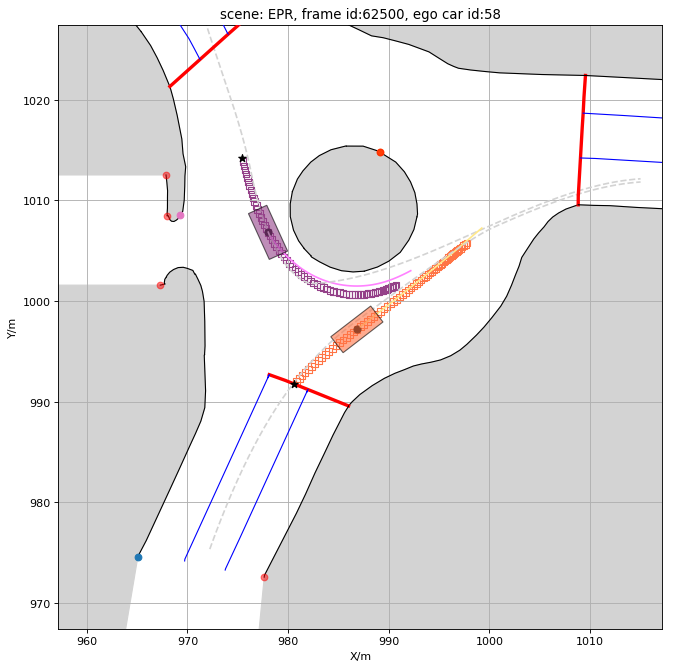

In [36]:
# a color map from https://www.jianshu.com/p/9007729d0d4f
colors = [(148, 65, 137), (255, 116, 69), (86, 156, 137), (202, 179, 158), (155, 99, 235),
          (161, 107, 108), (133, 160, 103), (76, 152, 126), (84, 62, 35), (44, 80, 130),
          (31, 184, 157), (101, 144, 77), (23, 197, 62), (141, 168, 145), (142, 151, 136),
          (115, 201, 77), (100, 216, 255), (57, 156, 36), (88, 108, 129), (105, 129, 112),
          (42, 137, 126), (155, 108, 249), (166, 148, 143), (81, 91, 87), (100, 124, 51),
          (73, 131, 121), (157, 210, 220), (134, 181, 60), (221, 223, 147), (123, 108, 131),
          (161, 66, 179), (163, 221, 160), (31, 146, 98), (99, 121, 30), (49, 89, 240),
          (116, 108, 9), (161, 176, 169), (80, 29, 135), (177, 105, 197), (139, 110, 246)]
colors = [(c[0]/255, c[1]/255, c[2]/255) for c in colors]
map_file = "D:/Downloads/INTERACTION-Dataset-DR-v1_0/maps/DR_USA_Roundabout_{}.osm".format('EP')
fig, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
plt.grid()
map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, 0, 0)
for i, car_id in enumerate(case['agents']):
    color = colors[i]
    color_pred = tuple([max(0, min(1, c*2)) for c in color])
    car = csv_sample[car_id]
    car_path = car['ref path']
    ref_xy = ref_paths[car_path]
    xy = case['xy'][car_id]
    xp = []
    yp = []
    for p in xy:
        if p != 'NaN':
            xp.append(p[0])
            yp.append(p[1])
    # plot the starting point
    plt.scatter(xp[0], yp[0], c='black', marker='*', s=50, zorder=30)
    # plot ground truth
    plt.scatter(xp[1:], yp[1:], marker='s', color='', edgecolor=color)
    # plot prediction
    plt.plot(np.array([x+0.03*i for i, x in enumerate(xp[20:])]), 
             np.array([y+0.03*i for i, y in enumerate(yp[20:])]), color=color_pred)
    # plot ref path
    plt.plot([p[0] for p in ref_xy], [p[1] for p in ref_xy], linestyle='dashed', c='lightgrey')
    # plot the car with rectangle in 20th frame
    update_objects_plot(sts+19*100, car, axes, color)
    # annotate the car's position with circle in 20th frame
    plt.scatter(xp[19], yp[19], s=40, c='black')
    x_20, y_20 = xy[20]
    plt.xlim(x_20-30, x_20+30)
    plt.ylim(y_20-30, y_20+30)
    plt.xlabel('X/m')
    plt.ylabel('Y/m')
    
plt.title('scene: {}, frame id:{}, ego car id:{}'.format(scene, sts+19*100, ego_car))
plt.savefig('figs/{}_eg1.pdf'.format(scene), format='pdf')
# plt.show()